In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, ConstantKernel as C
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

from george import kernels
import george
from astropy.io import fits
from functions import *
from gp_model_params import info

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
all_OGLE_info= pd.read_csv('lc_example/OGLE_Roman_field_variables.CSV')

In [3]:
types = ['LPV', 'RRLYR', 'T2CEP']

In [15]:
tp = 'RRLYR'
filename = info[tp]['example']
i = all_OGLE_info.index[all_OGLE_info.ID == filename]
ID = all_OGLE_info.ID[i].values[0]
period = all_OGLE_info.P_1[i].values[0]
df = read_OGLE_lc(ID, period)

In [16]:
df_modified = gap_reducer(df, period)

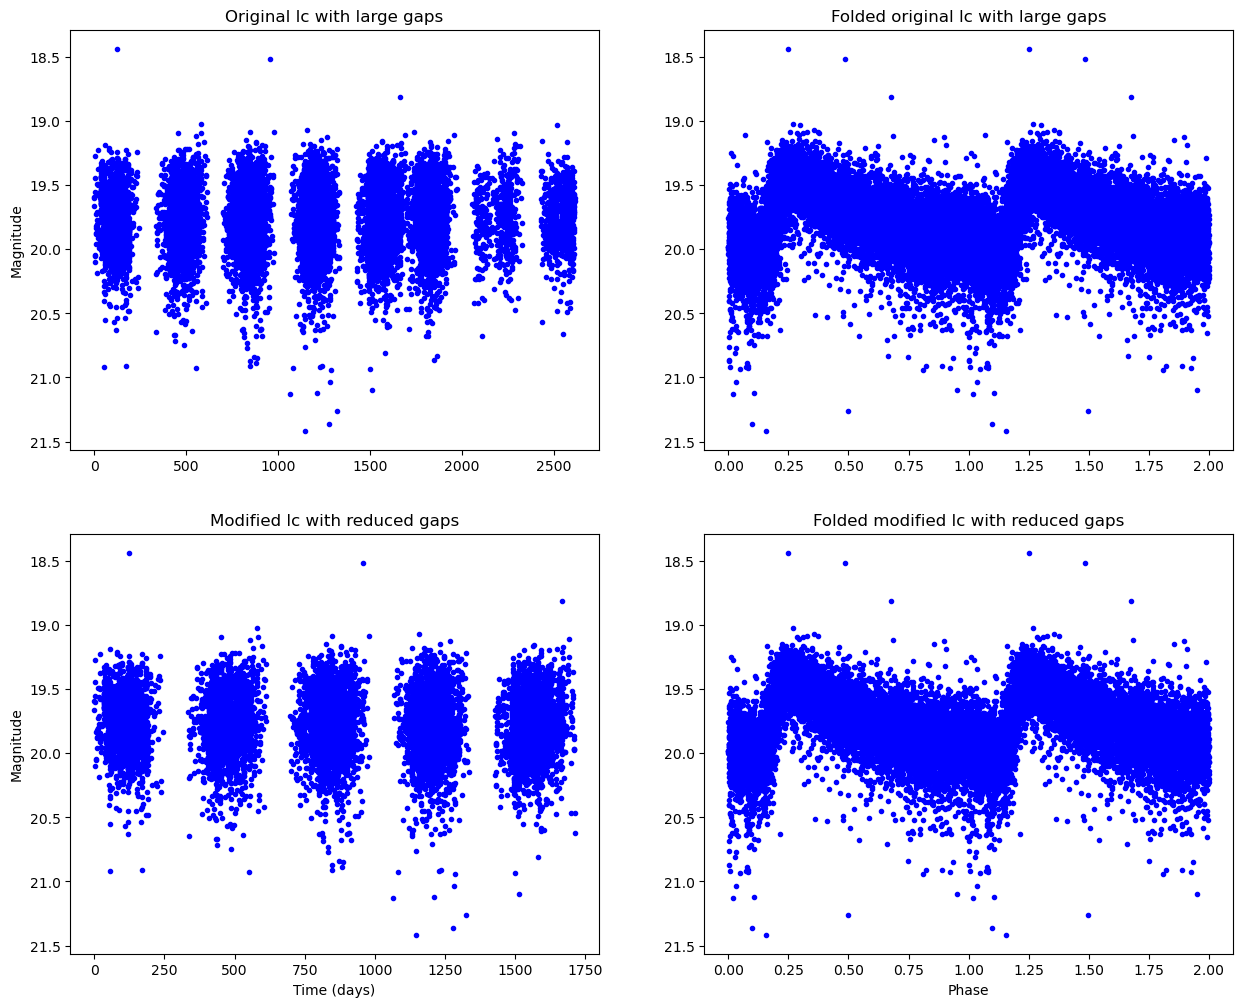

In [17]:
fig, axs = plt.subplots(2, 2)




axs[0,0].plot(df.t, df.m,'b.')
axs[0,1].plot(df.phase, df.m,'b.')
axs[0,1].plot(df.phase+1, df.m,'b.')

axs[1,0].plot(df_modified.t, df_modified.m,'b.')
axs[1,1].plot(df_modified.phase, df_modified.m,'b.')
axs[1,1].plot(df_modified.phase+1, df_modified.m,'b.')



axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,1].invert_yaxis()
axs[1,0].invert_yaxis()

axs[0,0].set_ylabel('Magnitude')
axs[0,0].set_title('Original lc with large gaps')
axs[0,1].set_title('Folded original lc with large gaps')
axs[1,0].set_ylabel('Magnitude')
axs[1,0].set_title('Modified lc with reduced gaps')
axs[1,1].set_title('Folded modified lc with reduced gaps')

axs[1,0].set_xlabel('Time (days)')
axs[1,1].set_xlabel('Phase')




fig = plt.gcf()
fig.set_size_inches(15.0,12.0)

In [18]:
# Read Roman time sampling
t_new = np.loadtxt('lc_example/ulwdc1_208_W149.txt', usecols=0)
t_new = t_new - min(t_new)

In [23]:
kernel = info[tp]['kernel']
p0 = info[tp]['p0']
if np.isinf(info[tp]['n_phs']):
    p0[0] = info[tp]['p0_period'](period)
else:
    p0[0] = info[tp]['p0_period'](info[tp]['n_phs'])
p0[1] = 1.5
gp = george.GP(kernel, solver= george.HODLRSolver)
gp.kernel.parameter_vector = p0
fit_binned = info[tp]['fit_binned']


x, y, e, X = prep_input(df_modified, tp, period)
y_median = np.median(y)
# y = y[x<np.max(t_new)

if fit_binned:
    x_fit, y_fit, e_fit = binning(x, y, e, bins = 4000)
    y_fit = y_fit - y_median
else:
    x_fit, y_fit, e_fit = x, y, e
    y_fit = y_fit - y_median

# Pre-compute the factorization of the matrix.
gp.compute(x_fit, e_fit)



# regular sampling in Roman observing window
t_prime = X

In [27]:
gp_opt = info[tp]['gp_opt']
if gp_opt:
    gp = opt_gp(p0, gp, x_fit, y_fit, s =.1)
    print(gp.kernel.parameter_vector)

[95.48612716 -5.61754345]


In [28]:
mu, cov = gp.predict(y_fit, t_prime)
std = np.sqrt(np.diag(cov))

if np.isinf(info[tp]['n_phs']):
    t_prime_new, mu_new = t_prime, mu
else:
    t_prime_new, mu_new = create_X_from_n_periods(info[tp]['n_phs'], 
                                                  t_prime, 
                                                  mu, 
                                                  period, 
                                                  np.max(t_new))
intpl = interp1d(t_prime_new, mu_new)
m_new = intpl(t_new)


# Read and apply Roman noise function
noise_fun = noise_function('cycle6_snr_curve.txt')
mu_err = noise_fun(m_new+y_median)




df_Roman = pd.DataFrame({'t': t_new, 'm': m_new , 'e': mu_err})

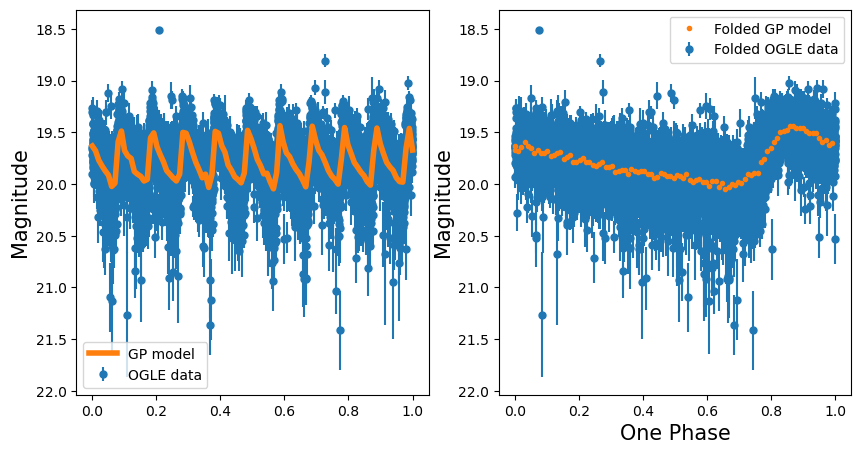

In [29]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
if np.isinf(info[tp]['n_phs']):
    tmp_period = period
else:
    tmp_period = 1/info[tp]['n_phs']
    
axs[0].errorbar(x, y,yerr=e, fmt = '.', ms = 10, label = 'OGLE data')

# axs[0].plot(bin_middles, bin_means, '.', zorder=11, label = 'Binned OGLE data')
axs[0].plot(t_prime,mu+y_median, linewidth = 4, label='GP model', zorder=11)
# axs[0].set_xlabel('%i Phases'%info[tp]['n_phs'], size=15)
axs[0].set_ylabel('Magnitude', size=15)
axs
axs[0].legend()
axs[0].invert_yaxis()

axs[1].errorbar((x/tmp_period)%1, y,yerr=e, fmt = '.', ms = 10, label = 'Folded OGLE data')

# axs[1].plot((bin_middles/tmp_period)%1, bin_means, '.', zorder=11, label='Binned OGLE data')
axs[1].plot((t_prime/tmp_period)%1,mu+y_median,'.', linewidth = 4, label='Folded GP model', zorder=11)
axs[1].set_xlabel('One Phase', size=15)
axs[1].set_ylabel('Magnitude', size=15)
axs[1].legend()
axs[1].invert_yaxis()

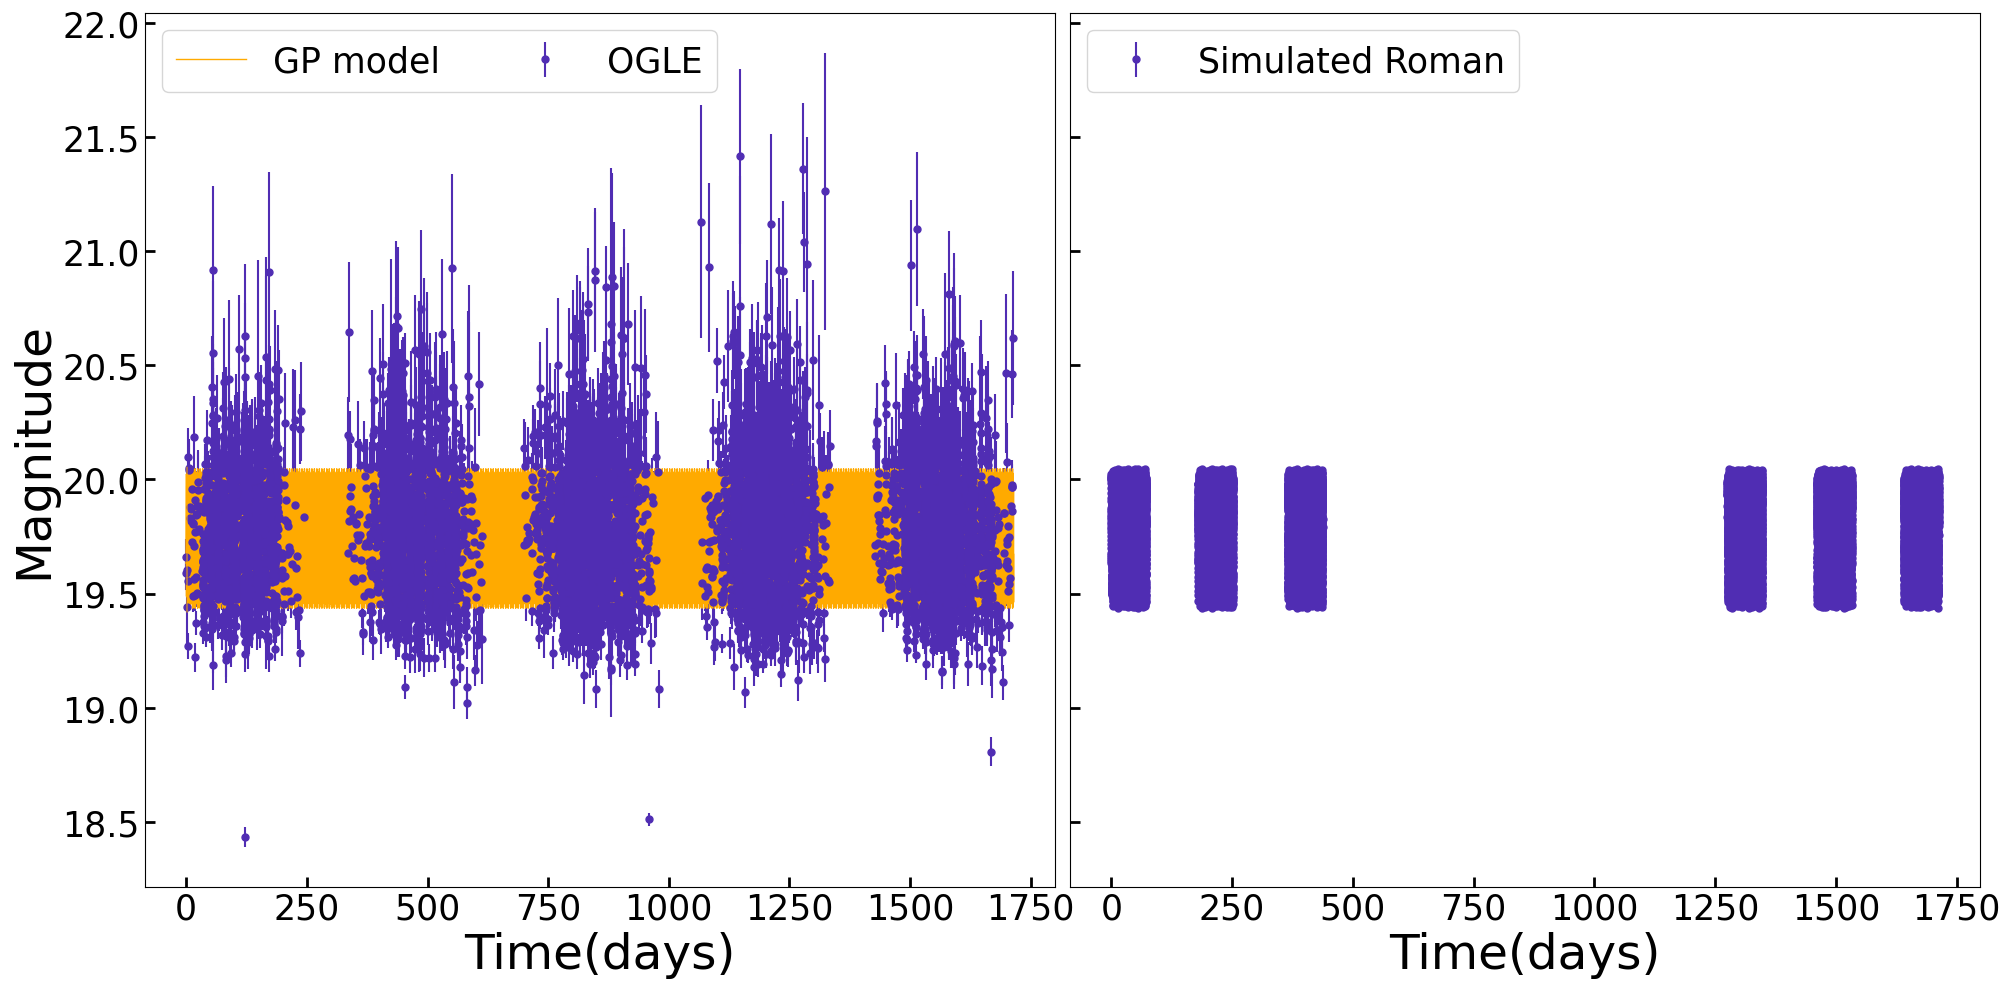

In [30]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)

data_color = '#502db3'
gp_color = '#ffaa00'

ax[0].errorbar(df_modified.t, 
               df_modified.m,
               yerr=df_modified.e, 
               fmt = '.', 
               ms=10, 
               color = data_color,
               label='OGLE')
ax[0].plot(t_prime_new, 
           mu_new+y_median, 
           color = gp_color,
           label='GP model', 
           linewidth=1)
ax[0].fill_between(t_prime, 
                   mu+y_median-std, 
                   mu+y_median+std, 
                   color = gp_color,
                   alpha=0.5,
                  zorder=11)

ax[0].set_xlabel('Time(days)', size=35)
ax[0].set_ylabel('Magnitude', size=35)
# plt.title(info.ID[i], size=25)
ax[0].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[0].legend(loc = 2, ncols=2, prop={'size':25})


ax[1].errorbar(df_Roman.t, 
               df_Roman.m+y_median,
               yerr=df_Roman.e, 
               color = data_color,
               fmt = '.', 
               ms=10, 
               label='Simulated Roman')
ax[1].set_xlabel('Time(days)', size=35)
ax[1].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[1].legend(loc = 2,prop={'size':25})
fig.tight_layout()
plt.savefig('OGLE_%s_full_lc_to_Roman_with_GP_model.jpg'%tp,facecolor='white', edgecolor='none', bbox_inches='tight')

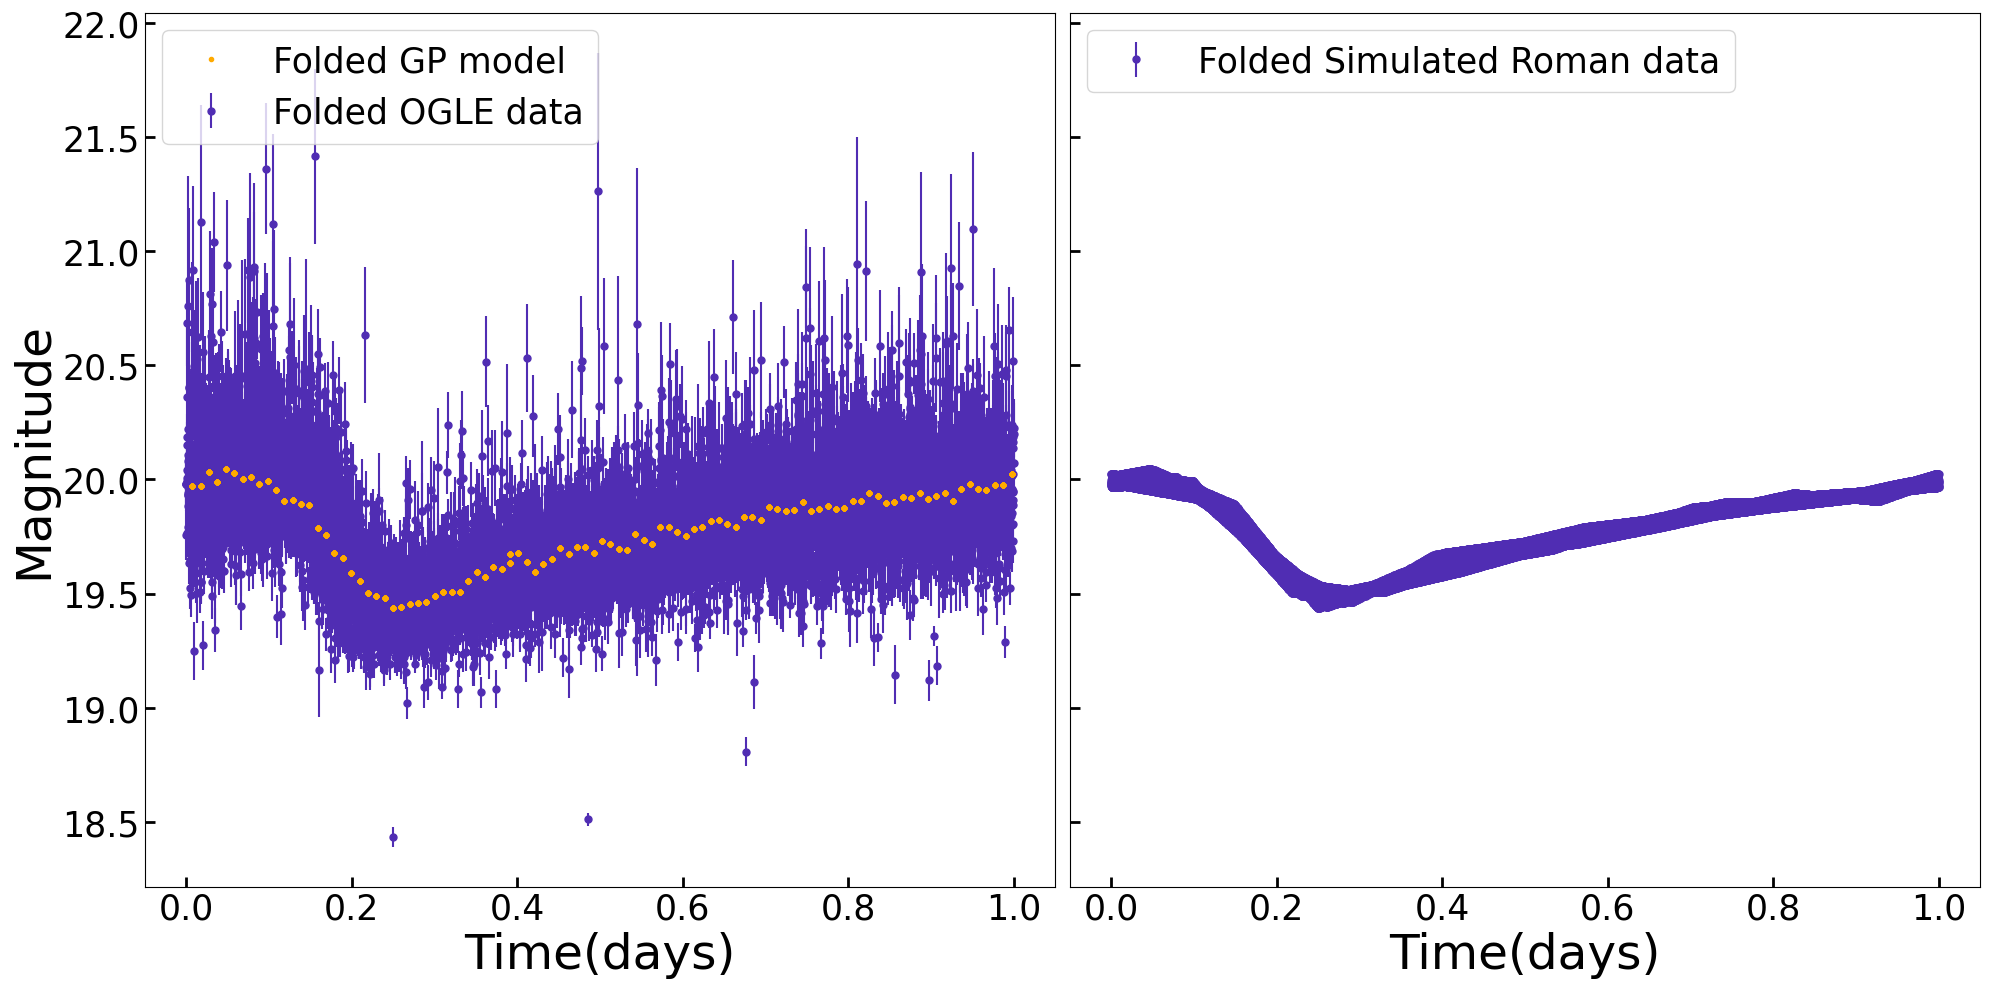

In [31]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)

t_prime_phase = T_0_fixer(t_prime_new, 
                          mu_new,
                          period, 
                          (t_prime_new/period)%1)
t_Roman_phase = T_0_fixer(df_Roman.t.values, 
                          df_Roman.m.values,
                          period, 
                          (df_Roman.t.values/period)%1)

ax[0].errorbar(df_modified.phase, 
               df_modified.m,
               yerr=df_modified.e, 
               color = data_color,
               fmt = '.', 
               ms=10, 
               label='Folded OGLE data')
ax[0].plot(t_prime_phase[np.argsort(t_prime_phase)], 
           mu_new[np.argsort(t_prime_phase)]+y_median, 
           '.',
           color = gp_color,
           label='Folded GP model', 
           zorder=11)
ax[0].set_xlabel('Time(days)', size=35)
ax[0].set_ylabel('Magnitude', size=35)
ax[0].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[0].legend(loc = 2,prop={'size':25})


ax[1].errorbar(t_Roman_phase, 
               df_Roman.m+y_median,
               yerr=df_Roman.e, 
               fmt = '.', 
               color = data_color,
               ms=10, 
               label='Folded Simulated Roman data')
ax[1].set_xlabel('Time(days)', size=35)
ax[1].tick_params(axis="both", direction="in", which="major", right=False, top=False, size=7, labelsize=25, width = 2)
ax[1].legend(loc = 2,prop={'size':25})
fig.tight_layout()
plt.savefig('OGLE_%s_folded_lc_to_Roman_with_GP_model.jpg'%tp,facecolor='white', edgecolor='none', bbox_inches='tight')